In [1]:
# import packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import requests
from scipy.signal import find_peaks

In [2]:
file_path = './hohonu_key.txt'  # key file in same directory

try:
    with open(file_path, 'r') as file:
        key = file.read()
        print("API Key:", key)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

API Key: f20cc902a6ce182a35ffda595df9c171fba1e4ee


### Station Info

In [3]:
import requests

url = "https://dashboard.hohonu.io/api/v1/stations/node-10075"

headers = {
    "accept": "application/json",
    "Authorization": key
}

station_info = requests.get(url, headers=headers)

station_info.text

'{"id":"hohonu-118","station_type":"Hohonu","latitude":43.8943,"longitude":-69.8148,"status":"Active","local_mllw":"-4.863033710031814","download_permision":true,"subscribed":false,"distance":{"value":0.0,"unit":"meters"},"images":null,"access":true,"current_datum":"MLLW","datums":[{"value":"MLLW","label":"MLLW"},{"value":"MHHW","label":"MHHW"},{"value":"NAVD","label":"NAVD88"},{"value":"D2W_FEET","label":"Local Measure (feet)"},{"value":"D2W","label":"Local Measure (mm)"}],"station_id":"hohonu-118","uuid":"17044513-e846-4afc-9efc-56b5d2b4903f","organization":"GMRI","notes":"","location":"Maine Maritime Museum, Kennebec River, Bath, ME","installation_date":"2022-11-08T04:00:00Z","decommissioned_date":null,"nnoaa_station":"8418150","custom_nearest_noaa":null,"nearest_noaa_subordinate_observed":null,"nearest_noaa_subordinate_prediction":null,"d2w_begin_caution":null,"d2w_begin_emergency":null,"navd88_begin_caution":null,"navd88_begin_emergency":null,"mllw_begin_caution":null,"mllw_begin_

### Station Statistics

In [4]:
GMRIstations = {
    'Portland - GMRI Pier':'10038',
    'Portland - Back Cove':'10076',
    'Bath':'10075',
    'St. George - Southern Island':'10072',
    'Boothbay Harbor':'10214',
    'Chebeague Island':'10202',
    'Portland - Fore River':'10237',
    'St. George - Port Clyde':'10211',
    'Machias - Ultrasonic':'10203',
    'Machias - Radar':'12002'
    
}
                

### API Request for data - saves raw data as a CSV so turn this cell on for a new call

In [5]:
sensorID = GMRIstations['Boothbay Harbor']

#define start/end dates: set to 00:00Z for both dates (i.e. will include only one measurement on end date but this matches NOAA)
start_date = '2022-11-10'
end_date = '2023-10-10'


# cleaned data?
clean = 'false'

#NAVD88
url1 = "https://dashboard.hohonu.io/api/v1/stations/node-"+sensorID+"/statistic/?from="+start_date+"%2000%3A00&to="+end_date+"%2000%3A00&datum=navd&cleaned="+clean+"&tz=0&format=json"

#MLLW
url2 = "https://dashboard.hohonu.io/api/v1/stations/node-"+sensorID+"/statistic/?from="+start_date+"%2000%3A00&to="+end_date+"%2000%3A00&datum=mllw&cleaned="+clean+"&tz=0&format=json"

#D2W
url3 = "https://dashboard.hohonu.io/api/v1/stations/node-"+sensorID+"/statistic/?from="+start_date+"%2000%3A00&to="+end_date+"%2000%3A00&datum=d2w&cleaned="+clean+"&tz=0&format=json"

headers = {"Authorization": key}

response1 = requests.get(url1, headers=headers)
print(response1.status_code)
response2 = requests.get(url2, headers=headers)
print(response2.status_code)
response3 = requests.get(url3, headers=headers)
print(response3.status_code)


## 200 = good response code
#########

df1 = response1.json()
df2 = response2.json()
df3 = response3.json()

# selecting individual time series from within the JSON dictionary
time = df1['data'][0]
htime = pd.DatetimeIndex(np.array(time)) # put Hohonu time values into an array with Datetime form

h_obs1 = df1['data'][1]
h_obs2 = df2['data'][1]
h_obs3 = df3['data'][1]

hobs1 = np.array(h_obs1, dtype = float)*0.3048 # put into an array and convert to metric
hobs2 = np.array(h_obs2, dtype = float)*0.3048
hobs3 = np.array(h_obs3, dtype = float)*0.001 # this comes in as mm -> convert to meters


data = {'date':time,'NAVD': hobs1, "MLLW": hobs2, "d2w": hobs3}
hohonu = pd.DataFrame(data=data)

hohonu.to_csv("Boothbay_hohonu_raw.csv")

200
200
200


In [6]:
df = pd.read_csv("Boothbay_hohonu_raw.csv") # Load in CSV
hobs1 = df.NAVD
hobs2 = df.MLLW
hobs3 = df.d2w
time = df.date

In [7]:
hdiff = hobs2-hobs1
print(hdiff)

0        1.566672
1        1.569720
2        1.569720
3        1.566672
4        1.566672
           ...   
31021    1.569720
31022    1.566672
31023    1.569720
31024    1.566672
31025         NaN
Length: 31026, dtype: float64


## Cleaning Hohonu Bath data (NAVD)

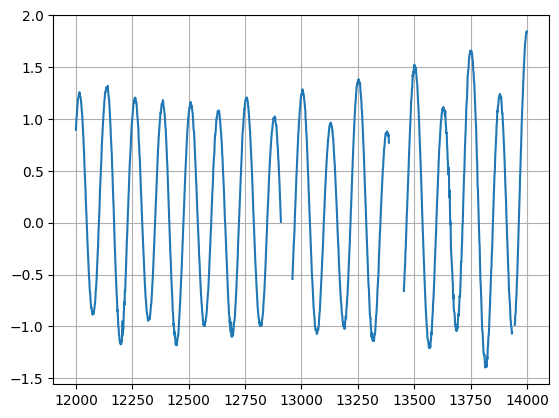

In [8]:
hobs11 = df.NAVD.copy()


##########
hobs11[12910:12960] = np.nan

hobs11[13389:13454] = np.nan
hobs11[13935:13946] = np.nan

hobs11[20270:20280] = np.nan
hobs11[20370:20400] = np.nan

hobs11[22753:22800] = np.nan

hobs11[22990:23025] = np.nan

hobs11[23470:23480] = np.nan

hobs11[23720:23780] = np.nan

hobs11[24180:24231] = np.nan
hobs11[24210] = 1.4
hobs11[24320:24395] = np.nan
hobs11[24488:24550] = np.nan

hobs11[24640:24655] = np.nan

hobs11[25265:25330] = np.nan
hobs11[25380:25420] = np.nan
hobs11[25300] = 1.4
hobs11[25425:25525] = np.nan
hobs11[25495] = -1.2
hobs11[25605:25634] = np.nan
hobs11[25620] = -1.2
hobs11[25960:25980] = np.nan

##### SLICE PARAMETER #####
q = slice(12000,14000)
###########################

# plt.plot(htime[12000:13000], hobs11[12000:13000])
plt.plot(hobs11[q])
# plt.plot(htime[q], df['NAVD'][q])
# plt.plot(hobs11[q])
plt.grid()



In [9]:
hobs11 = pd.DataFrame(hobs11)
hobs1a = pd.DataFrame(hobs1)

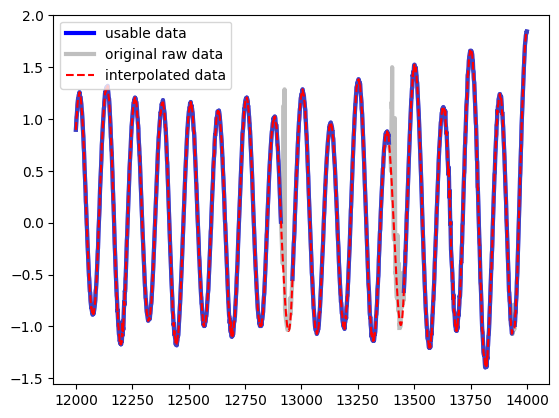

In [10]:
hobsint = hobs11.interpolate(method='polynomial', order=3)
# hobsint2 = hobs11[q].interpolate(method='polynomial', order=2)
plt.plot(hobs11[q], c = 'b', lw = 3, label = 'usable data')
plt.plot(hobs1a[q], c = '0.5', lw = 3, alpha = 0.5, label = 'original raw data')
plt.plot(hobsint[q], c= 'r', ls = '--', label = 'interpolated data')
plt.legend(loc = 'upper left')
plt.savefig("cleaning_example.png")

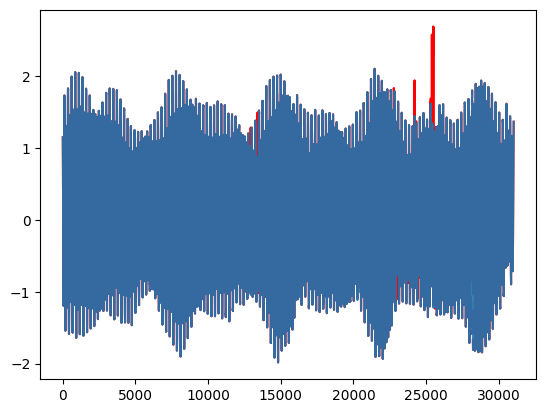

In [11]:
plt.plot(hobs1, c = 'r')
plt.plot(hobsint, alpha = 0.9)

## Saving CSV to use in calculating datums (From NOAA CO-OPS)

In [12]:
df = pd.DataFrame(hobsint.values, index = time,  columns = ['WL'])

In [13]:
df.index = pd.to_datetime(df.index)

In [14]:
# Resample the DataFrame to 6-minute intervals and insert missing rows with empty values
resampled_df = df.resample('6T').asfreq()

In [15]:
# round everything to 3 decimals
wl= []
for obs in resampled_df.WL.values:
    wl.append(np.round(obs.data,3))
resampled_df.WL = wl
time_resamp = resampled_df.index.strftime('%m/%d/%Y %H:%M')
df = resampled_df.set_index(time_resamp)

In [16]:
df.head()

,WL
date,
06/02/2023 15:00,1.152
06/02/2023 15:06,1.128
06/02/2023 15:12,1.091
06/02/2023 15:18,1.082
06/02/2023 15:24,1.064


In [17]:
# save final data as CSV
df.to_csv('boothbay_cleaned.csv', header = ['wl'])

Calculate datums using NOAA CO-OPS data calculator: https://access.co-ops.nos.noaa.gov/datumcalc/